In [3]:
# !pip install diffusers transformers accelerate safetensors torch --quiet
# !pip install opencv-python-headless scikit-image pillow matplotlib numpy --quiet

In [1]:
import cv2
import numpy as np
from skimage import measure
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline
import torch

In [10]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    dtype=torch.float32
).to("cpu")

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Keyword arguments {'dtype': torch.float32} are not expected by StableDiffusionInpaintPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [3]:
# ------------------------------------------------------------
# FUNÇÃO 1 — Detectar áreas danificadas automaticamente
# ------------------------------------------------------------
def detectar_anomalia(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9,9), 0)

    # threshold automático
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # remover ruído
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)

    # encontrar contornos
    contornos = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    if len(contornos) == 0:
        raise ValueError("Nenhuma anomalia detectada!")

    # pegar o maior contorno
    maior = max(contornos, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(maior)

    # máscara final
    mask_final = np.zeros_like(gray)
    cv2.drawContours(mask_final, [maior], -1, 255, -1)

    return mask_final, (x, y, w, h)

In [4]:
# ------------------------------------------------------------
# FUNÇÃO 2 — Gerar crop da Imagem
# ------------------------------------------------------------
def crop_anomalia(img, bbox):
    x, y, w, h = bbox
    crop = img[y:y+h, x:x+w]
    return crop

In [7]:
# ------------------------------------------------------------
# FUNÇÃO 3 — Outpainting
# ------------------------------------------------------------
def outpaint(img, mask):
    pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    pil_mask = Image.fromarray(mask)

    result = pipe(
        prompt="repair the damaged region realistically",
        image=pil_img,
        mask_image=pil_mask,
        guidance_scale=7.5,
        num_inference_steps=5
    ).images[0]

    return result

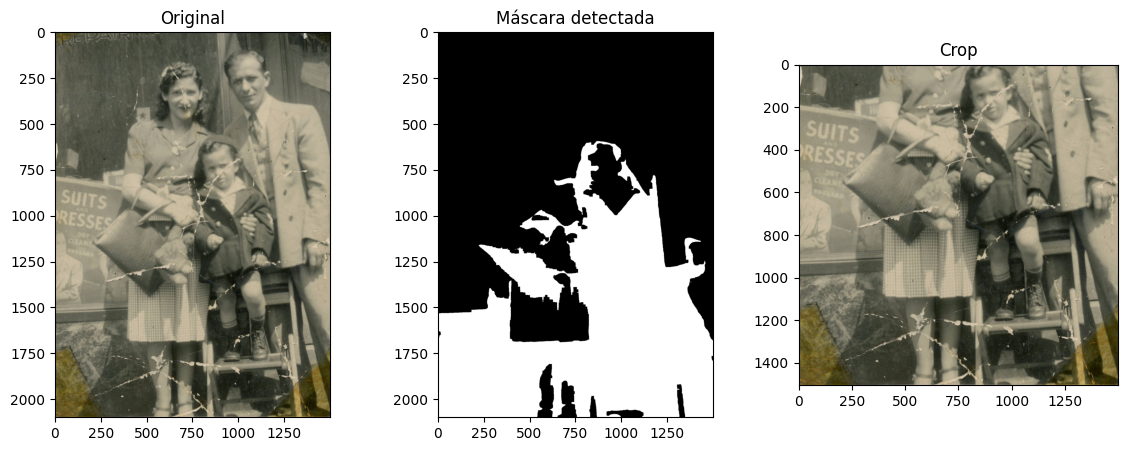

  0%|          | 0/5 [00:00<?, ?it/s]

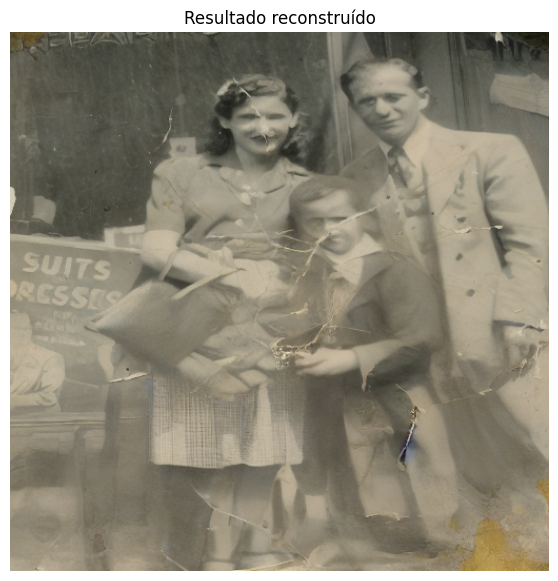

In [12]:
img = cv2.imread("/content/to_restore2.jpg")

# 1 - Detectar anomalia
mask, bbox = detectar_anomalia(img)

# 2 - Crop (opcional, caso deseje mostrar)
crop = crop_anomalia(img, bbox)

plt.figure(figsize=(14,5))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(mask, cmap='gray'); plt.title("Máscara detectada")
plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)); plt.title("Crop")
plt.show()

# 3 - OUTPAINTING (INPAINTING da anomalia)
resultado = outpaint(img, mask)

plt.figure(figsize=(7,7))
plt.imshow(resultado)
plt.title("Resultado reconstruído")
plt.axis("off")
plt.show()